In [1]:
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd.variable import Variable
from torchvision import datasets, transforms
from PIL import Image

In [2]:
print(sys.version)
device='cuda'

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
CUDA is available!  Training on GPU ...


In [3]:
 folder_data = glob.glob("../input/celeba-dataset/img_align_celeba/img_align_celeba/*.jpg")
 len_data = len(folder_data)
 print(len_data)

 train_image_paths = folder_data[0:200000]

 class TrainDataset(Dataset):
   def __init__(self, image_paths, train=True):
     self.image_paths = image_paths
     self.transforms = transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
     
   def __getitem__(self, index):
     image = Image.open(self.image_paths[index])
     t_image = self.transforms(image)
     return t_image

   def __len__(self):
     return len(self.image_paths)


202599


In [4]:
train_dataset = TrainDataset(train_image_paths,train = True)
print(len(train_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

200000


In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [6]:
class GeneratorNet(torch.nn.Module):
  def __init__(self):
    super(GeneratorNet, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(100, 1024, kernel_size = 4, stride = 1, padding = 0, bias = False),
        nn.BatchNorm2d(1024),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(1024, 512, kernel_size = 4, stride = 2, padding = 1, bias =False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace = True),

        nn.ConvTranspose2d(128, 3, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.Tanh()
    )
    

  def forward(self, x):
    #print(x)
    x = self.main(x)
    #print(x.shape)
    return x

generator = GeneratorNet()
generator.float()
generator = generator.to(device)

generator.apply(weights_init)

print(generator)

GeneratorNet(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh

In [7]:
class DiscriminatorNet(torch.nn.Module):
  def __init__(self):
    super(DiscriminatorNet, self).__init__()
    self.main = nn.Sequential(
      nn.Conv2d(3, 128, kernel_size = 5, stride = 2, padding = 2, bias = False),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(128, 256, kernel_size = 5, stride = 2, padding = 2, bias = False),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(256, 512, kernel_size = 5, stride = 2, padding =2, bias = False),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(512, 1024, kernel_size = 5, stride = 2, padding = 2, bias = False),
      nn.BatchNorm2d(1024),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(1024, 1, kernel_size = 4, stride = 1, padding = 0, bias = False)
    )
    
  def forward(self, x):
    x = self.main(x)
    return x

discriminator = DiscriminatorNet()
discriminator.float()
discriminator = discriminator.to(device)

discriminator.apply(weights_init)

print(discriminator)

DiscriminatorNet(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizerG = optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [9]:
def noise(size):
  n = Variable(torch.randn(size, 100, 1, 1))
  n = n.to(device)
  return n

samples = 16
fixed_noise = noise(samples)

Epoch No. = 1
Discriminator Loss = 0.9868535995483398 Generator Loss = 6.128769397735596


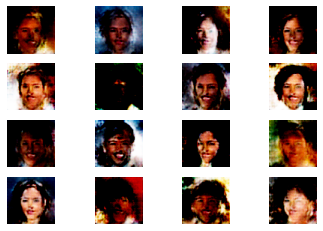

Epoch No. = 2
Discriminator Loss = 0.8857666850090027 Generator Loss = 3.404183864593506


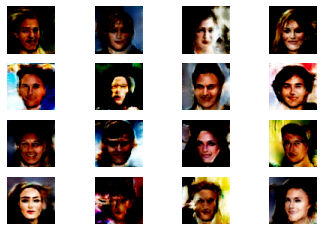

Epoch No. = 3
Discriminator Loss = 0.9738831520080566 Generator Loss = 2.6495656967163086


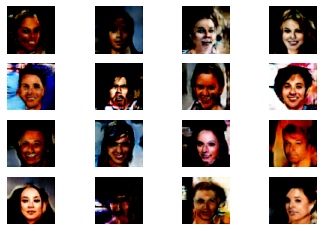

Epoch No. = 4
Discriminator Loss = 0.9926220774650574 Generator Loss = 2.4378154277801514


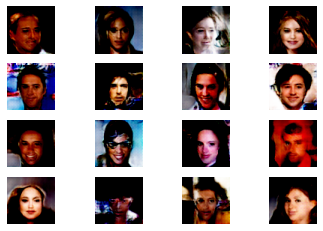

Epoch No. = 5
Discriminator Loss = 0.9510147571563721 Generator Loss = 2.459716558456421


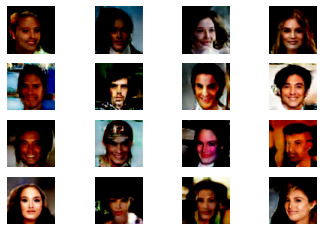

Epoch No. = 6
Discriminator Loss = 0.9045372605323792 Generator Loss = 2.558741807937622


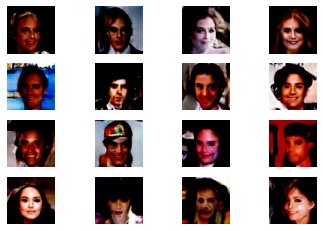

Epoch No. = 7
Discriminator Loss = 0.8456876873970032 Generator Loss = 2.6779632568359375


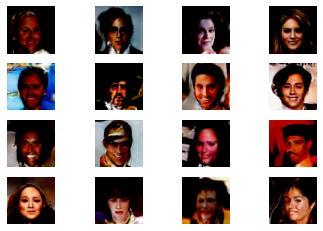

Epoch No. = 8
Discriminator Loss = 0.7496967911720276 Generator Loss = 2.9265923500061035


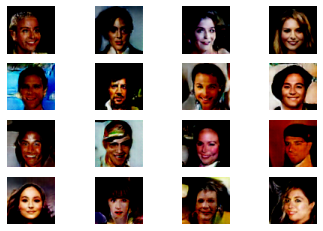

Epoch No. = 9
Discriminator Loss = 0.7140932679176331 Generator Loss = 3.048264503479004


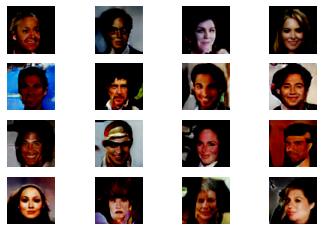

Epoch No. = 10
Discriminator Loss = 0.6762086153030396 Generator Loss = 3.146857976913452


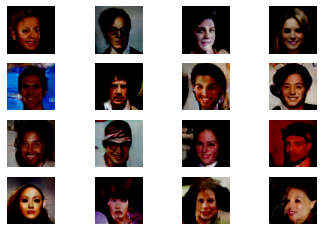

Epoch No. = 11
Discriminator Loss = 0.6256327033042908 Generator Loss = 3.33180570602417


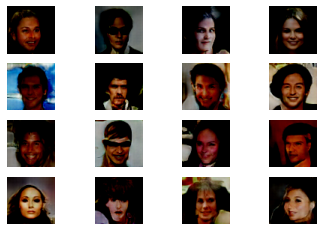

Epoch No. = 12
Discriminator Loss = 0.6018702387809753 Generator Loss = 3.420743703842163


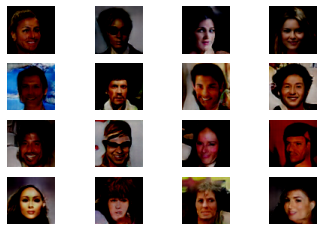

Epoch No. = 13
Discriminator Loss = 0.5681424736976624 Generator Loss = 3.571789026260376


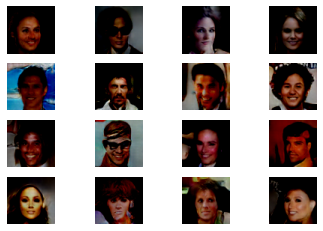

Epoch No. = 14
Discriminator Loss = 0.5293201208114624 Generator Loss = 3.7754533290863037


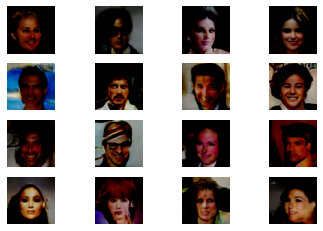

Epoch No. = 15
Discriminator Loss = 0.5496415495872498 Generator Loss = 3.758349895477295


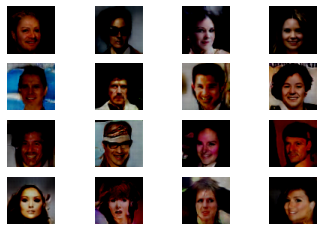

Epoch No. = 16
Discriminator Loss = 0.4498995244503021 Generator Loss = 4.017961502075195


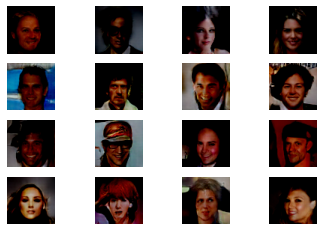

Epoch No. = 17
Discriminator Loss = 0.44200384616851807 Generator Loss = 4.164365768432617


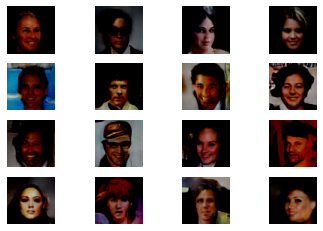

Epoch No. = 18
Discriminator Loss = 0.44333750009536743 Generator Loss = 4.213131427764893


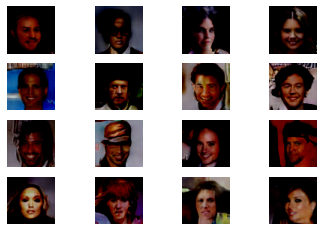

Epoch No. = 19
Discriminator Loss = 0.3753213584423065 Generator Loss = 4.444507122039795


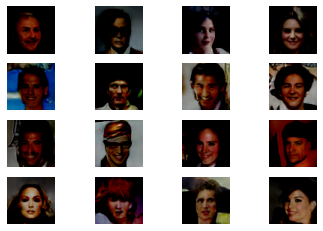

Epoch No. = 20
Discriminator Loss = 0.41218850016593933 Generator Loss = 4.410614490509033


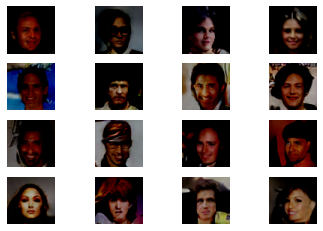

Epoch No. = 21
Discriminator Loss = 0.3937934339046478 Generator Loss = 4.592789173126221


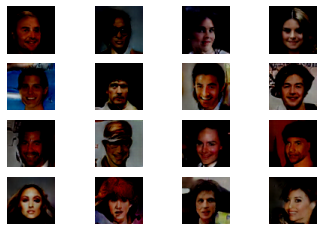

Epoch No. = 22
Discriminator Loss = 0.38613012433052063 Generator Loss = 4.577732563018799


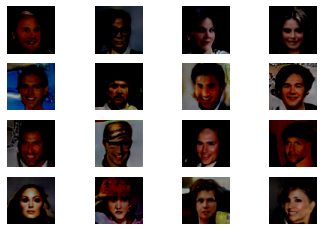

Epoch No. = 23
Discriminator Loss = 0.33511537313461304 Generator Loss = 4.731830596923828


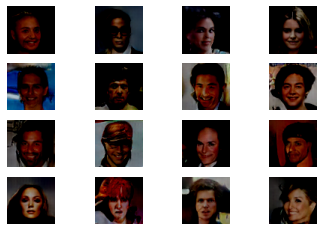

Epoch No. = 24
Discriminator Loss = 0.34836649894714355 Generator Loss = 4.785647392272949


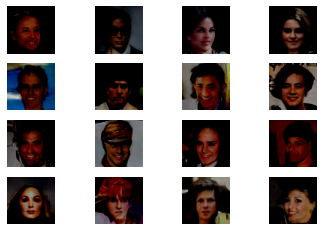

Epoch No. = 25
Discriminator Loss = 0.3605821132659912 Generator Loss = 4.770617961883545


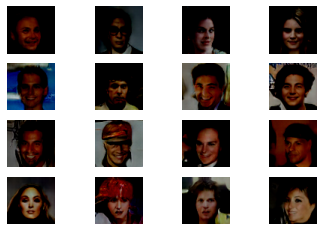

Epoch No. = 26
Discriminator Loss = 0.4009897708892822 Generator Loss = 4.666635036468506


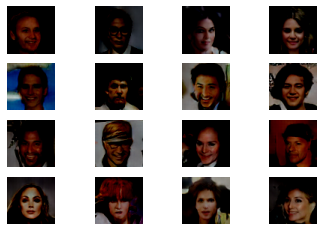

Epoch No. = 27
Discriminator Loss = 0.30044206976890564 Generator Loss = 4.908768177032471


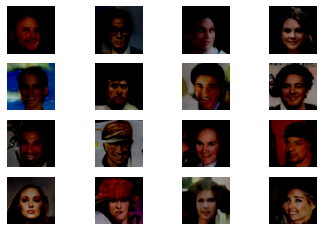

Epoch No. = 28
Discriminator Loss = 0.33025798201560974 Generator Loss = 4.986913681030273


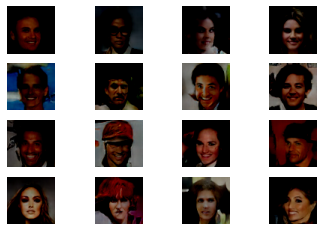

Epoch No. = 29
Discriminator Loss = 0.28913620114326477 Generator Loss = 5.124215602874756


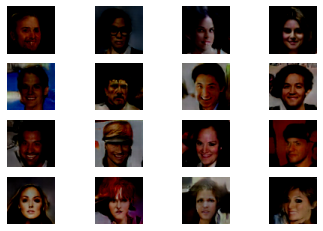

Epoch No. = 30
Discriminator Loss = 0.30191975831985474 Generator Loss = 5.151367664337158


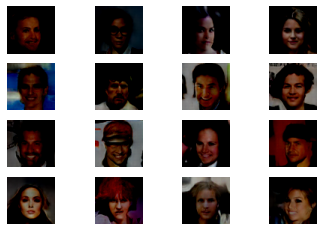

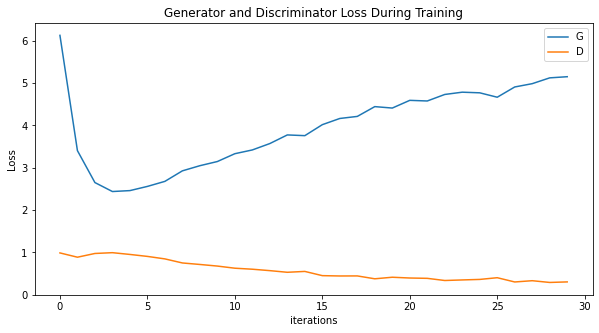

In [10]:
lossesD = []
lossesG = []

num_epochs = 30
for epoch in range(num_epochs):
  discriminator.train()
  generator.train()
  lossD = 0
  lossG = 0
  prob_real = 0
  prob_fake = 0 
  for num_iter, (real_batch) in enumerate(train_loader):

    x_real = Variable(real_batch).to(device)
    optimizerD.zero_grad()
    pred_real = discriminator(x_real)
    loss_real = criterion(pred_real.view(-1,1), torch.ones((x_real.size(0),1),device='cuda'))
    loss_real.backward()
    z = noise(x_real.size(0))
    x_fake = generator(z)
    x_fake.detach()
    pred_fake = discriminator(x_fake)
    loss_fake = criterion(pred_fake.view(-1,1), torch.zeros((x_real.size(0),1),device='cuda'))
    loss_fake.backward()
    optimizerD.step()
    lossD = lossD + loss_real + loss_fake

    fake_x = generator(z)
    optimizerG.zero_grad()
    fake_pred = discriminator(fake_x)
    loss_gen = criterion(fake_pred.view(-1,1), torch.ones((x_real.size(0),1),device='cuda'))
    loss_gen.backward()
    optimizerG.step()
    lossG = lossG + loss_gen

  lossesD.append(lossD/len(train_loader))
  lossesG.append(lossG/len(train_loader))
  print("Epoch No. = "+ str(epoch+1))
  print("Discriminator Loss = "+ str(lossesD[epoch].item()), "Generator Loss = "+ str(lossesG[epoch].item()))
  if (epoch+1)%5==0 or (epoch+1)>25:
    torch.save(generator.state_dict(),'g_epoch-{}.pth'.format(epoch+1))
    torch.save(discriminator.state_dict(), 'd_epoch-{}.pth'.format(epoch+1))

  with torch.no_grad():
    generated_images = generator(fixed_noise.detach())
    for i in range(16):
      plt.subplot(4, 4, 1 + i)
      plt.axis('off')
      plt.imshow(np.transpose(generated_images.cpu().numpy()[i],(1,2,0)))
    plt.show()  

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(lossesG,label="G")
plt.plot(lossesD,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

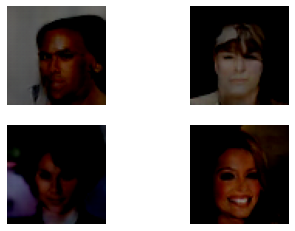

In [12]:
test_noise = noise(4)
with torch.no_grad():
  test_images = generator(test_noise.detach())
  for i in range(4):
	  plt.subplot(2, 2, 1 + i)
	  plt.axis('off')
	  plt.imshow(np.transpose(test_images.cpu().numpy()[i],(1,2,0)))
  plt.show()

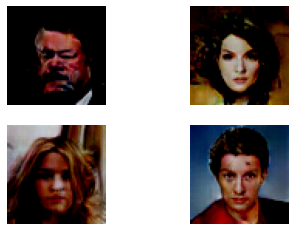

In [13]:
test_noise = noise(4)
with torch.no_grad():
  test_images = generator(test_noise.detach())
  for i in range(4):
	  plt.subplot(2, 2, 1 + i)
	  plt.axis('off')
	  plt.imshow(np.transpose(test_images.cpu().numpy()[i],(1,2,0)))
  plt.show()

In [ ]:
test_noise = noise(4)
with torch.no_grad():
  test_images = generator(test_noise.detach())
  for i in range(4):
	  plt.subplot(2, 2, 1 + i)
	  plt.axis('off')
	  plt.imshow(np.transpose(test_images.cpu().numpy()[i],(1,2,0)))
  plt.show()